In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy.spatial.distance import euclidean, minkowski, cityblock
from IPython.display import display

from WH1Utils import *

In [2]:
def getData(file):
    data = pd.read_table(file, sep=",", names=['x', 'y', 'class'])
    return data

In [3]:
def showData(data):
    colorsMap = ['#000000', '#FFFFFF']
    plt.scatter(data['x'].as_matrix(), 
                data['y'].as_matrix(), 
                c=[colorsMap[n] for n in data['class'].as_matrix()])
    plt.show()

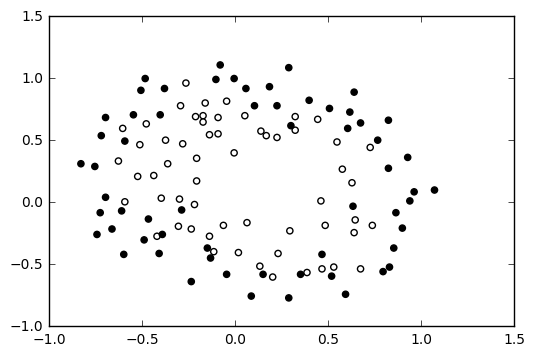

In [4]:
data = getData("chips.txt")
showData(data)

In [5]:
def kNN(k, trainSet, testSet, metric, kernel):
    answers = []
    for testPoint in testSet:
        testDist = [[metric(testPoint[0], trainPoint[0]), trainPoint[1]] for trainPoint in trainSet]
        testDist.sort(key=lambda d:d[0])
        pointClass = 0
        for i in range(k):
            if testDist[i][1] == 1:
                pointClass += kernel(testDist[i][0])
            else:
                pointClass -= kernel(testDist[i][0])
        if pointClass > 0:
            pointClass = 1
        else:
            pointClass = 0
        answers.append([testPoint[0], pointClass])
    return answers

In [6]:
def training(data, k, foldsCount, metric, kernel, draw=False):
    averageAccuracy = 0
    cv = kFold(len(data), foldsCount, shuffle=True)
    for train_index, test_index in cv:
        trainSet = [data[i] for i in train_index]
        testSet = [data[i] for i in test_index]
        classifierAnswers = kNN(k, trainSet, testSet, metric, kernel)
        accuracy = f1_score([point[1] for point in testSet], [point[1] for point in classifierAnswers])
        averageAccuracy += accuracy
        if draw:
            showTrainingResult(testSet, classifierAnswers)
    averageAccuracy /= foldsCount
    return averageAccuracy

In [7]:
points = data[['x', 'y']].as_matrix()
classes = data['class'].as_matrix()

metrics = [(euclidean, 'Euclidean'), (cityblock, 'Manhattan'), (lambda x, y: (minkowski(x, y, 3)), 'Minkowski (3)')]
transformations = [(lambda point: (point[0], point[1]), 'None'),
                   (lambda point: (point[0], point[1], math.sqrt(1 + point[0]**2 + point[1]**2)), 'Add sqrt(1 + x^2 + y^2)'),
                   (lambda point: (point[0], point[1], point[0]**2 + point[1]**2), 'Add x^2 + y^2')]

kernel_functions = [(lambda distance: 1, 'Simple'),
                    (lambda distance: 1/distance, 'Inversely proportional'),
                    (lambda distance: (3 / 4) * (1 - distance * distance), 'Epanechnikov')]

statistics = pd.DataFrame(columns=['Nearest Neighbors', 'Folds', 'Metric', 'Transformation', 'Kernel', 'Accuracy'])
for k in (3, 8, 9):
    for foldsCount in (5, 10):
        for metric in metrics:
            for transformation in transformations:
                for kernel in kernel_functions:
                    transformedPoints = list(map(transformation[0], points))
                    dataForTraining = [[transformedPoints[i], classes[i]] for i in range(len(classes))]
                    averageAccuracy = training(dataForTraining, k, foldsCount, metric[0], kernel[0])
                    result = pd.DataFrame([[k, foldsCount, metric[1], transformation[1], kernel[1], averageAccuracy]], columns=['Nearest Neighbors', 'Folds', 'Metric', 'Transformation', 'Kernel', 'Accuracy'])
                    statistics = statistics.append(result, ignore_index=True)

In [8]:
def highlight_max_accuracy(s):
    is_max = s == s.max()
    return ['background-color: yellow' if val else '' for val in is_max]

statistics.style.apply(highlight_max_accuracy, subset=['Accuracy'])

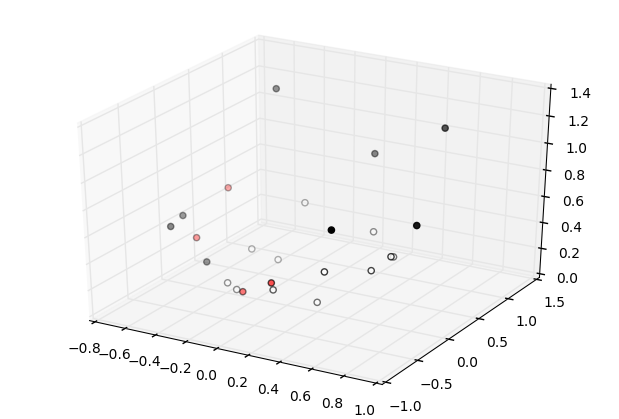

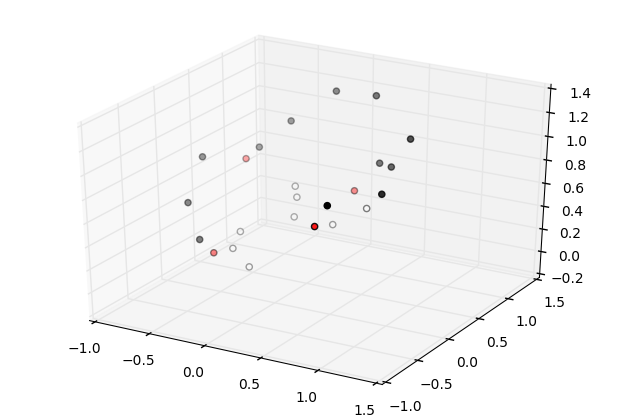

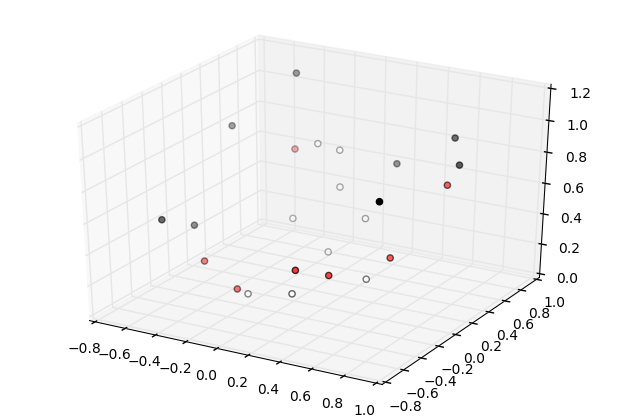

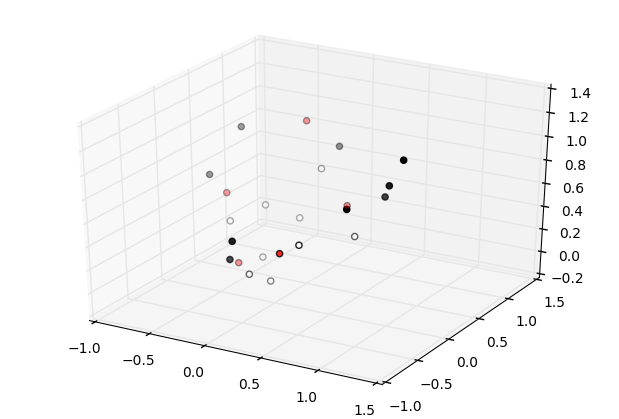

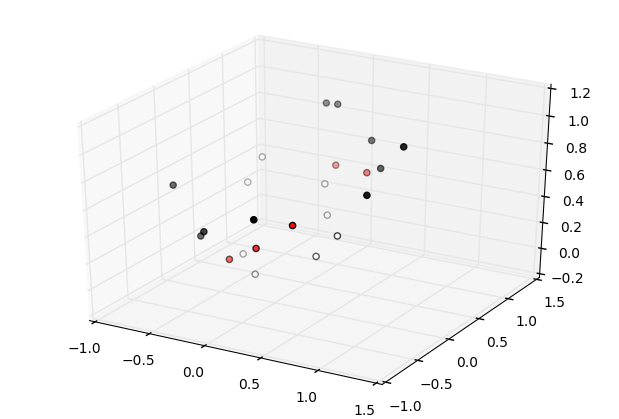

0.7843312629399586

In [15]:
# best result visualization
transformedPoints = list(map(transformations[2][0], points))
dataForTraining = [[transformedPoints[i], classes[i]] for i in range(len(classes))]
training(dataForTraining, 8, 5, metrics[1][0], kernel_functions[1][0], draw=True)

In [10]:
# leave one out
transformedPoints = list(map(transformations[2][0], points))
dataForTraining = [[transformedPoints[i], classes[i]] for i in range(len(classes))]
training(dataForTraining, 9, 118, metrics[2][0], kernel_functions[2][0])

0.8050847457627118